In [38]:
import numpy as np
import matplotlib.pyplot as plt

class Model(object):
    
    def __init__(self, tumorlabel = 'Tumor', tumorcolor = 'red', 
                 healthylabel = 'Normal', healthycolor = 'blue', 
                 immunelabel = 'Imune', immunecolor = 'black'):
        
        self.tumorColor = tumorcolor
        self.healthyColor = healthycolor
        self.immuneColor = immunecolor    
        self.tumorLabel = tumorlabel
        self.healthyLabel = healthylabel
        self.immuneLabel = immunelabel
        
        
        
    def setParameters(self, r1, b1, c1, d1, r2, b2, c2, c3, c4, s, p, x, steps, timestep
                      , totalDose = 1, fractionalDose = 1, DEMO = False, codeProtocolo = 1):
        self.tumorGrow = r1
        self.tumorReg = b1
        self.immuneDieToTumor = c1
        self.immuneDie = d1
        self.healthyGrow = r2
        self.healthyReg = b2
        self.tumorDieToImmune = c2
        self.tumorDieToNormal = c3
        self.normalDieToTumor = c4
        self.immuneEntry = s
        self.immuneResponse = p
        self.immuneLimit = x
        self.steps = steps
        self.timestep = timestep
        self.time = np.zeros(int(self.steps / self.timestep), dtype=np.float64)
        self.healthy = np.zeros(int(self.steps / self.timestep), dtype=np.float64)
        self.tumor = np.zeros(int(self.steps / self.timestep), dtype=np.float64)
        self.immune = np.zeros(int(self.steps / self.timestep), dtype=np.float64)
        
        self.totalDose = totalDose
        self.fractionalDose = fractionalDose
        self.numberFraction = self.totalDose / self.fractionalDose
        self.demo = DEMO
        self.protocolo = codeProtocolo
        
    def survivalFraction(self, i):
        return np.exp((-self.alfa[i] * self.fractionalDose) - (self.beta[i] * self.fractionalDose* self.fractionalDose))
        
    def fractionCellDeath_values(self):
        # Os paramentros radiobiologicos do modelo linear quadrático a e b, são baseados em dados clinicos e experimentos in vitro.
        a1 = 0.1
        b1 = 0.011
        a2 = a1/2
        b2 = b1/2
        a3 = a2
        b3 = b2
        
        self.alfa = np.array([a1, a2, a3])
        self.beta = np.array([b1, b2, b3])
        self.gama = 1
        
        if(self.demo):
            
            retorno = {
                1: np.array([0.4082, 0.2320, 0.2320]), #I - Convencional
                2: np.array([0.5207, 0.3084, 0.3084]), #II - Hipofracionamento
                3: np.array([0.4961, 0.2909, 0.2909]), #III - Hipofracionamento
                4: np.array([0.549, 0.329, 0.329]),    #IV - Hipofracionamento
                5: np.array([0.2131, 0.1140, 0.1140])  #V - Convencional
            }[self.protocolo]
        else:
            retorno = np.array([1.0,1.0,1.0])
            for i in range(3):
                retorno[i] = (retorno[i] - self.survivalFraction(i))
            
            
        return retorno;
        
    def initialConditions(self, healthy_zero, tumor_zero, immune_zero, time_zero = 0.0):
        self.healthy[0] = healthy_zero
        self.tumor[0] = tumor_zero
        self.immune[0] = immune_zero
        self.time[0] = time_zero
        
    def function_xyz(self, N, T, I):
        x = float(self.healthyGrow * N * (1 - self.healthyReg * N) - self.normalDieToTumor * T * N)
        y = float(self.tumorGrow * T * (1 - self.tumorReg * T) - self.tumorDieToImmune * I * T - self.tumorDieToNormal * T * N)
        z = float(self.immuneEntry + ((self.immuneResponse * I * T)/(self.immuneLimit + T)) - self.immuneDieToTumor * I * T - self.immuneDie * I)
        return np.array([x, y, z])
            
    def process(self, with_radiotheraphy = False):
        days_application = 0
        rest_days = 0
        applied_dose = 0
        
        steps_i = int(self.steps / self.timestep)
        day_ = int(steps_i/self.steps)
        
        count = 0
        
        if(with_radiotheraphy):
            self.fractionDeath = self.fractionCellDeath_values()
        
        
        for i in range(0, steps_i - 1):            
            
            if(with_radiotheraphy and i % day_ == 0):
                count += 1
                
                if(days_application < 5 and applied_dose < self.totalDose):
                    self.healthy[i] = (1 - self.fractionDeath[1])*self.healthy[i]
                    self.tumor[i] = (1 - self.fractionDeath[0])*self.tumor[i]
                    self.immune[i] = (1 - self.fractionDeath[2])*self.immune[i]
                
                    days_application+=1
                    rest_days = 0
                    applied_dose += self.fractionalDose
                else:
                    rest_days+=1
                    if(rest_days == 2):
                        days_application = 0
                
                if(False):
                    print(count, i, 'Dias Tratamento: ', days_application , ' Dias de Repouso: ', rest_days)
                    
            self.rungeKutta4Method_step(i)
                    
        
    def rungeKutta4Method_step(self, i):
        
            k1 = self.timestep * self.function_xyz(self.healthy[i], self.tumor[i], self.immune[i])
            k2 = self.timestep * self.function_xyz(self.healthy[i] + (self.timestep * k1[0])/2, self.tumor[i] + (self.timestep * k1[1])/2, self.immune[i] + (self.timestep * k1[2])/2)
            k3 = self.timestep * self.function_xyz(self.healthy[i] + (self.timestep * k2[0])/2, self.tumor[i] + (self.timestep * k2[1])/2, self.immune[i] + (self.timestep * k2[2])/2)
            k4 = self.timestep * self.function_xyz(self.healthy[i] + self.timestep * k3[0], self.tumor[i] + self.timestep * k3[1], self.immune[i] + self.timestep * k3[2])
            
            self.time[i + 1] = self.time[i] + self.timestep
            self.healthy[i+1] = self.healthy[i] + ((1/6) * (k1[0] + 2*(k2[0] + k3[0]) + k4[0]))
            self.tumor[i+1] = self.tumor[i] + ((1/6) * (k1[1] + 2*(k2[1] + k3[1]) + k4[1]))
            self.immune[i+1] = self.immune[i] + ((1/6) * (k1[2] + 2*(k2[2] + k3[2]) + k4[2]))
            
    def plot(self,xLabel='Tempo', filename='print.png', size=(7,3.5)):
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(size)
        
        #ax1 = fig1.add_subplot(111)
        ax[0].set_xlabel(xLabel)
        ax[0].plot(self.time, self.tumor, label=self.tumorLabel, color=self.tumorColor)
        ax[0].plot(self.time, self.healthy, label = self.healthyLabel, color = self.healthyColor)
        ax[0].plot(self.time, self.immune, label = self.immuneLabel, color = self.immuneColor)
        ax[0].grid(True)
        ax[0].legend()
        
        ax[1].set_xlabel(self.healthyLabel)
        ax[1].set_ylabel(self.tumorLabel)
        ax[1].plot(self.healthy, self.tumor, color='black')
        ax[1].grid(True)
        plt.show()
        
    def print_time(self):
        print(self.time)


<center>
    <h2>APLICAÇÃO DE CONTROLE CONTÍNUO POR PARTES PARA UM MODELO DE CRESCIMENTO DE TUMORES DE MAMA COM TRATAMENTO POR RADIOTERAPIA</h2>
    <h3>TANISIA DE CARLI FOLETTO</h3>
    <br/>
    <a href="http://livros01.livrosgratis.com.br/cp055589.pdf" target="_blank">download</a>
</center>



<h2><li>Modelo</li></h2>

<h1>
$$
\left \{
\begin{array}{rl}
\dot N = & r_2 N (1-b_2N)-c_4 TN \\
\dot T = & r_1 T (1-b_1T)-c_2 IT - c_3 TN \\
\dot I = & s+\dfrac{\rho I T}{\chi + T} - c_1 I T - d_1 I
\end{array}
\right .
$$
</h1>

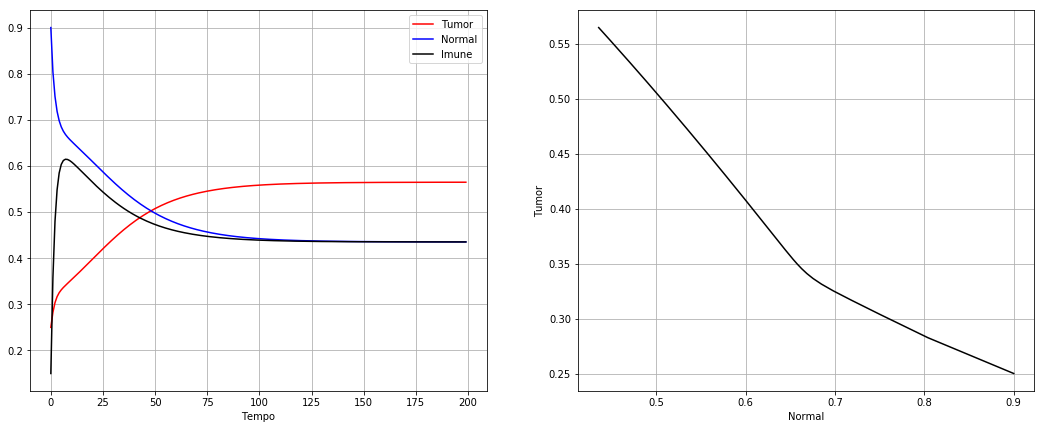

In [39]:

# analise do comportamento do modelo com os parametros estimados em 2.6 e condicoes iniciais estimadas em 2.7
model = Model()
# (r1, b1, c1, d1, r2, c2, c3, c4, s, p, x, steps, timestep)
model.setParameters(1.5, 1, 1, 0.2, 1, 1, 0.5, 1, 1, 0.33, 0.01, 0.3, 200, 1)
model.initialConditions(0.9, 0.25, 0.15) # (N, T, I)
model.process()
model.plot(size=(18, 7))

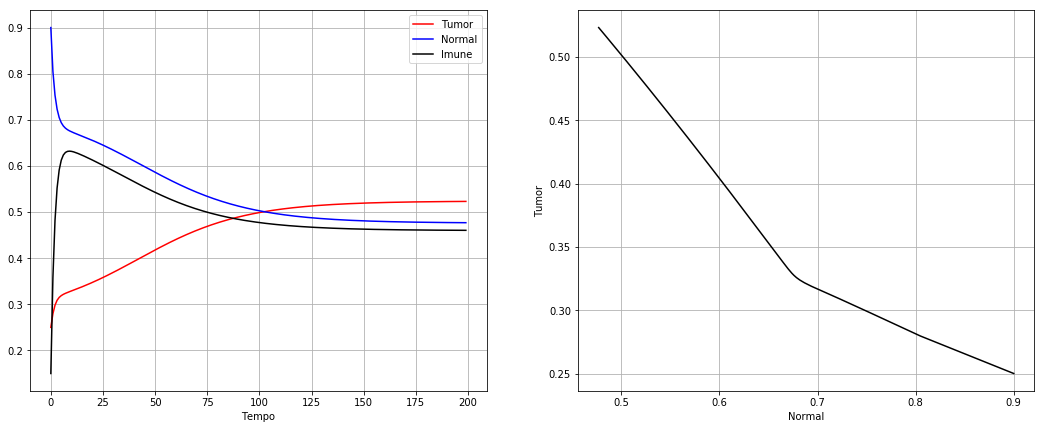

In [40]:
# analise do comportamento do modelo com os parametros ajustados para o cancer de mama
# a taxa de crescimento do tumor é alterada para simular o tempo de duplicacao
model = Model()
# (r1, b1, c1, d1, r2, c2, c3, c4, s, p, x, days, timestep em horas)
model.setParameters(1.483, 1, 1, 0.2, 1, 1, 0.5, 1, 1, 0.33, 0.01, 0.3, 200, 1)
model.initialConditions(0.9, 0.25, 0.15) # (N, T, I)
model.process()
model.plot(size=(18, 7))

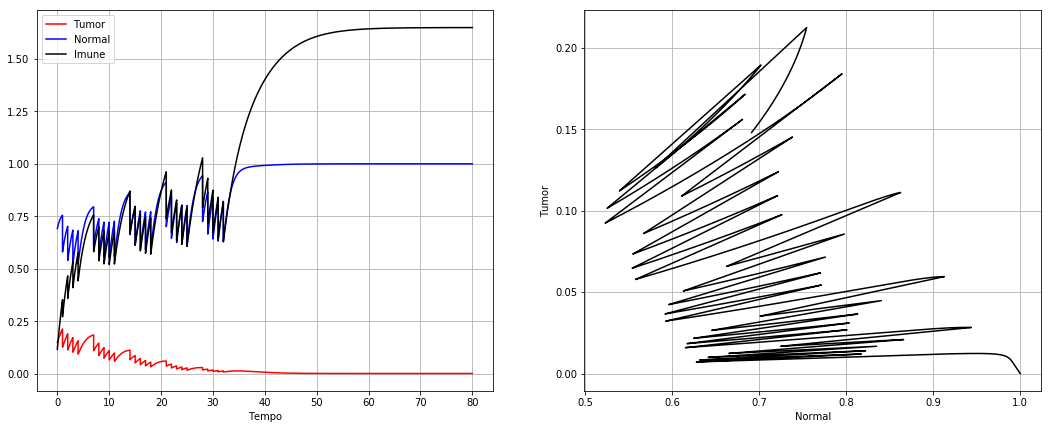

In [41]:
model = Model()
# (r1, b1, c1, d1, r2, c2, c3, c4, s, p, x, days, timestep em horas, dose total, dose fracionada, fracao de morte demo, Protocolo)
model.setParameters(1.483, 1, 1, 0.2, 1, 1, 0.5, 1, 1, 0.33, 0.01, 0.3, 80, 0.00009,50,2, True)
model.initialConditions(0.9, 0.25, 0.15) # (N, T, I)
model.process(True)
model.plot(size=(18, 7))

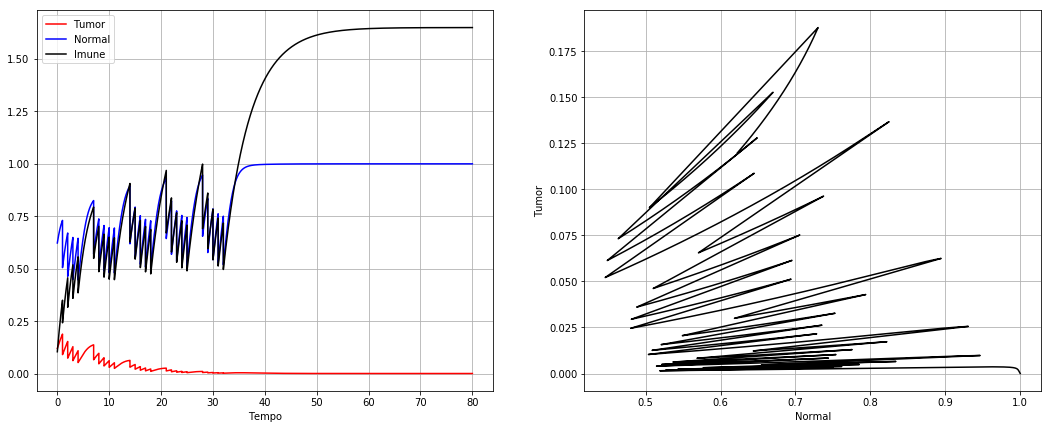

In [42]:
model = Model()
# (r1, b1, c1, d1, r2, c2, c3, c4, s, p, x, days, timestep em horas, dose total, dose fracionada, fracao de morte demo, Protocolo)
model.setParameters(1.483, 1, 1, 0.2, 1, 1, 0.5, 1, 1, 0.33, 0.01, 0.3, 80, 0.00009,50,2, True, 2)
model.initialConditions(0.9, 0.25, 0.15) # (N, T, I)
model.process(True)
model.plot(size=(18, 7))

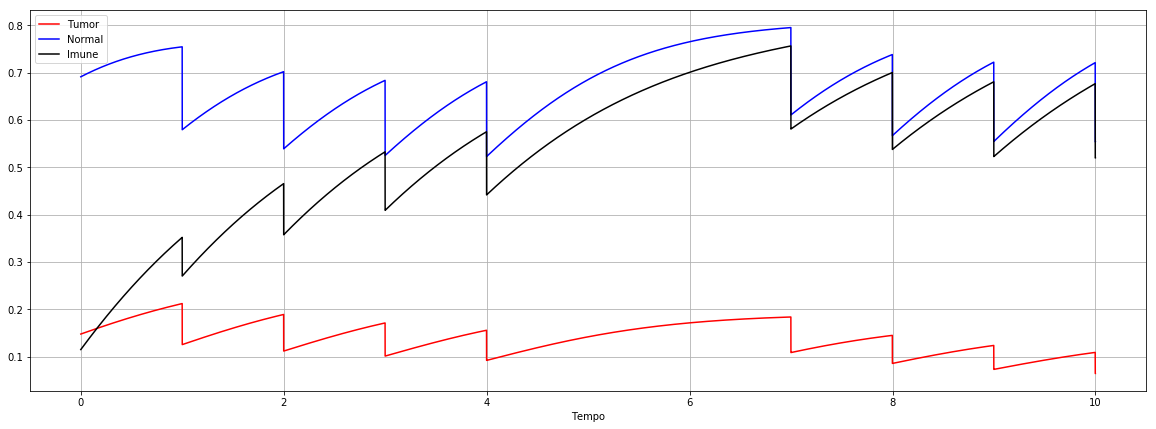

In [6]:
model = Model()
# (r1, b1, c1, d1, r2, c2, c3, c4, s, p, x, days, timestep em horas, dose total, dose fracionada, fracao de morte demo, Protocolo)
model.setParameters(1.483, 1, 1, 0.2, 1, 1, 0.5, 1, 1, 0.33, 0.01, 0.3, 10, 0.00069,50,2,True,3)
model.initialConditions(0.9, 0.25, 0.15) # (N, T, I)
model.process(True)
model.plot_vs_time(size=(20, 7))

In [252]:
model.fractionDeath

array([0.4082, 0.232 , 0.232 ])